# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.



In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
con=sqlite3.connect(r"C:\Users\DELL\Desktop\database.sqlite")

In [3]:
filtered_data=pd.read_sql_query(""" SELECT *FROM Reviews WHERE Score != 3 LIMIT 100000""",con)

In [4]:
def partition(x):
    if x<3:
        return "negative"
    return "positive"
    
actual_score=filtered_data["Score"]
positive_negative=actual_score.map(partition)
filtered_data["Score"]=positive_negative

In [5]:
filtered_data.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
99995,108619,B001EQ4E3I,A1LKMGTP4M5EZ4,xx,0,0,positive,1312070400,Choc milk milk,"My fave chocolate milk mix, have no idea why i..."
99996,108620,B001EQ4E3I,ADRYHOAJ0BCKU,Frequent Amazon Shopper,0,0,positive,1306886400,"great addition to protein shakes, hot cocoa, o...",Why can't I get this in a supermarket? It's g...
99997,108621,B001EQ4E3I,AN27WFRJPBYD2,Pokemon Master250,0,0,positive,1305417600,No Sugar - No Difference,My favorite chocolate milk powder since i was ...
99998,108622,B001EQ4E3I,A31OWYSZNPL9E,"Carolyn M. Young ""Caroline""",0,0,positive,1299715200,love this product,This is a great product for those looking to r...
99999,108623,B001EQ4E3I,AAX6OMHQC1BN3,"J. Cook ""J Cook""",0,0,positive,1296345600,Tastes better with less sugar and fewer calories,"I decided to buy the ""no sugar added"" version ..."


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:

display.head()

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


# Exploratory data analysis

# deduplication

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [9]:
#sorting data according to product id ascending order
sorted_data = filtered_data.sort_values("ProductId",axis=0,ascending=True,inplace=False,kind="quicksort",na_position="last")

In [10]:
final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

In [11]:
(final_data["Id"].size*1/filtered_data["Id"].size*1)*100

87.775

In [12]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [13]:
final_data["Score"].value_counts()

positive    73592
negative    14181
Name: Score, dtype: int64

# Preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

1:Hence in the Preprocessing phase we do the following in the order below:-

2:Begin by removing the html tags

3:Remove any punctuations or limited set of special characters like , or . or # etc.

4:Check if the word is made up of english letters and is not alpha-numeric

5:Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

6:Convert the word to lowercase

7:Remove Stopwords

8:Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

8:After which we collect the words used to describe positive and negative revi

In [14]:
# printing some random reviews
sent_0 = final_data['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final_data['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_data['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
import re
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [19]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [20]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'would',\
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [21]:
from bs4 import BeautifulSoup
preprocessed_reviews = []
for sentance in final_data['Text'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [22]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [23]:
final_data["CleanedText"]=preprocessed_reviews

In [24]:
final_data["CleanedText"][1500]

'chips tasty nice size serving calories good grab go snack busy moms'

In [25]:
final_data["Time"]=pd.to_datetime(final_data["Time"], unit="s")
final_data=final_data.sort_values(by="Time")


# 4:Featurization

# 4.1 BoW

In [26]:
X=final_data["CleanedText"].values
y=final_data["Score"]

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_1,X_test,y_1,y_test=train_test_split(X,y,test_size=0.3,random_state=3)
X_train,X_cv,y_train,y_cv=train_test_split(X_1,y_1)

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
count_vect=CountVectorizer().fit(X_train)

In [31]:
X_tr=count_vect.transform(X_train)
X_cv=count_vect.transform(X_cv)
X_test=count_vect.transform(X_test)
print("type of X_tr :", type(X_tr))
print("shape of _x_tr:",X_tr.get_shape())
print("count of unique words:",X_tr.get_shape()[1])

type of X_tr : <class 'scipy.sparse.csr.csr_matrix'>
shape of _x_tr: (46080, 40663)
count of unique words: 40663


In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
scaler=StandardScaler(with_mean=False).fit(X_tr)
X_tr=scaler.transform(X_tr)
X_cv=scaler.transform(X_cv)
X_test=scaler.transform(X_test)

# Hyperparameter tuning

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_auc_score


In [35]:
# Creating alpha values in the range from 10^-3 to 10^3
range_alpha=[10**x for x in range(-4,4)]


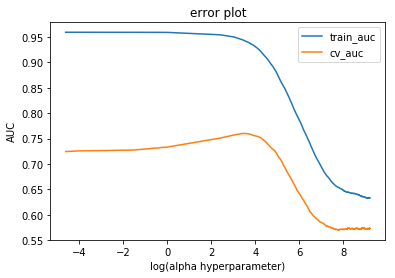

In [36]:
train_auc=[]
cv_auc=[]
for i in range_alpha:
    nb=MultinomialNB(alpha=i)
    nb.fit(X_tr,y_train)
    y_tr_predict=nb.predict_proba(X_tr)[:,1]
    y_cv_predict=nb.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_train,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv,y_cv_predict))
    
plt.plot(np.log(range_alpha), train_auc,label="train_auc")
plt.plot(np.log(range_alpha), cv_auc,label="cv_auc")
plt.xlabel("log(alpha hyperparameter)")
plt.ylabel("AUC")
plt.legend()
plt.title("error plot")
plt.show()


In [37]:
optimal_alpha_bow=range_alpha[cv_auc.index(max(cv_auc))]
print("/n optimal value of alpha is %3.f." %optimal_alpha_bow)

/n optimal value of alpha is  31.


Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



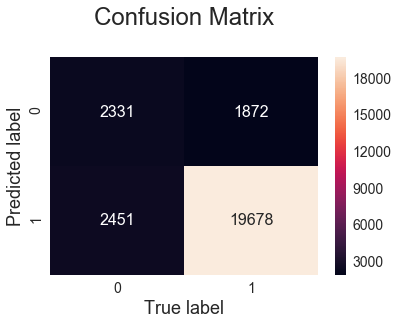

In [38]:
# ====================================multinomial NB with optimal alpha====================================================#
optimal_NB=MultinomialNB(alpha=optimal_alpha_bow)
optimal_NB.fit(X_tr,y_train)
y_tr_pred=optimal_NB.predict(X_tr)
y_test_pred=optimal_NB.predict(X_test)
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


In [39]:
#evaluating accuracy
test_acc_bow=accuracy_score(y_test, y_test_pred)*100
print("accuracy at alpha={} is {}" .format(optimal_alpha_bow,test_acc_bow))
tr_acc_bow=accuracy_score(y_train, y_tr_pred)*100
print("accuracy at alpha={} is {}" .format(optimal_alpha_bow,tr_acc_bow))
#evaluating preciission
precision_bow=precision_score(y_test, y_test_pred,pos_label="positive")*100
print("precission score at alpha={} is {}" .format(optimal_alpha_bow,precision_score))
#evaluating recaall
recall_bow=recall_score(y_test,y_test_pred,pos_label="positive")*100
print("recall score at alpha {} is {}" .format(optimal_alpha_bow,recall_bow))
#evaluating f1 score
f1_bow=f1_score(y_test,y_test_pred,pos_label="positive")*100
print("f1_score at alpha={} is {}" .format(optimal_alpha_bow,f1_bow))

accuracy at alpha=31 is 83.58271304876196
accuracy at alpha=31 is 93.06640625
precission score at alpha=31 is <function precision_score at 0x000002041D9ED268>
recall score at alpha 31 is 88.92403633241447
f1_score at alpha=31 is 90.10279539366745


In [40]:
optimal_NB.classes_

array(['negative', 'positive'], dtype='<U8')

# Top features

In [41]:
# Now we can find log probabilities of different features for both the classes
class_features = optimal_NB.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))

Top 20 Important Features and their log probabilities For Negative Class :


not	 -->	-6.543944  
like	 -->	-7.111081  
taste	 -->	-7.133301  
product	 -->	-7.174375  
bad	 -->	-7.347030  
disappointed	 -->	-7.372622  
one	 -->	-7.396138  
money	 -->	-7.425396  
even	 -->	-7.426708  
no	 -->	-7.428008  
could	 -->	-7.494490  
buy	 -->	-7.508024  
thought	 -->	-7.508914  
bought	 -->	-7.531329  
worst	 -->	-7.570064  
get	 -->	-7.581592  
flavor	 -->	-7.591406  
away	 -->	-7.606049  
much	 -->	-7.607087  
waste	 -->	-7.608682  


Top 20 Important Features and their log probabilities For Positive Class :


not	 -->	-6.746199  
great	 -->	-6.866985  
good	 -->	-6.938284  
like	 -->	-7.008045  
love	 -->	-7.057754  
one	 -->	-7.125880  
taste	 -->	-7.195931  
flavor	 -->	-7.232331  
get	 -->	-7.283264  
best	 -->	-7.293663  
really	 -->	-7.317948  
product	 -->	-7.339902  
little	 -->	-7.355218  
find	 -->	-7.355400  
also	 -->	-7.358865  
much	 -->	-7.363524  
time	 -->	-7.370492  
price	

# tf_idf


In [42]:
X=final_data["CleanedText"].values
y=final_data["Score"]

In [43]:
from sklearn.model_selection import train_test_split
X_1,X_test,y_1,y_test=train_test_split(X,y,test_size=0.3,random_state=3)
X_train,X_cv,y_train,y_cv=train_test_split(X_1,y_1)

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10).fit(X_train)

In [45]:
X_tr=tfidf_vect.transform(X_train)
X_cv=tfidf_vect.transform(X_cv)
X_test=tfidf_vect.transform(X_test)

In [46]:
from sklearn.preprocessing import StandardScaler

In [47]:
scaler=StandardScaler(with_mean=False).fit(X_tr)
X_tr=scaler.transform(X_tr)
X_cv=scaler.transform(X_cv)
X_test=scaler.transform(X_test)

# Hyperparameter tuning

In [48]:
from sklearn.naive_bayes import MultinomialNB


In [49]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score

In [50]:
# Creating alpha values in the range from 10^-3 to 10^3
range_alpha=[10**x for x in range(-4,4)]


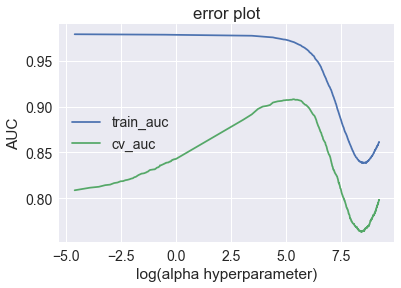

In [51]:
train_auc=[]
cv_auc=[]
for i in range_alpha:
    nb=MultinomialNB(alpha=i)
    nb.fit(X_tr,y_train)
    y_tr_pred=nb.predict_proba(X_tr)[:,1]
    y_cv_pred=nb.predict_proba(X_cv)[:,1]
    train_auc.append(roc_auc_score(y_train,y_tr_pred))
    cv_auc.append(roc_auc_score(y_cv,y_cv_pred))
    
plt.plot(np.log(range_alpha), train_auc,label="train_auc")
plt.plot(np.log(range_alpha), cv_auc,label="cv_auc")
plt.xlabel("log(alpha) hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.title("error plot")
plt.show()    

In [52]:
optimal_alpha_tfidf=range_alpha[cv_auc.index(max(cv_auc))]
print("optimal alpha for tfidf is {}" .format(optimal_alpha_tfidf))


optimal alpha for tfidf is 211


Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



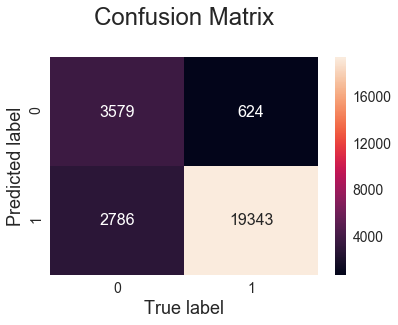

In [53]:
#training model at optimal alpha
optimal_nb_tfidf=MultinomialNB(alpha=optimal_alpha_tfidf)
optimal_nb_tfidf.fit(X_tr,y_train)
y_test_pred=optimal_nb_tfidf.predict(X_test)
y_tr_pred=optimal_nb_tfidf.predict(X_tr)
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [54]:
#evaluating accuracy
tr_acc_tfidf=accuracy_score(y_train, y_tr_pred)*100
print("accuracy at alpha={} is {}" .format(optimal_alpha_tfidf,tr_acc_tfidf))
test_acc_tfidf=accuracy_score(y_test, y_test_pred)*100
print("accuracy at alpha={} is {}" .format(optimal_alpha_tfidf,test_acc_tfidf))
#evaluating preciission
precision_tfidf=precision_score(y_test, y_test_pred,pos_label="positive")*100
print("precission score at alpha={} is {}" .format(optimal_alpha_tfidf,precision_tfidf))
#evaluating recaall
recall_tfidf=recall_score(y_test,y_test_pred,pos_label="positive")*100
print("recall score at alpha {} is {}" .format(optimal_alpha_tfidf,recall_tfidf))
#evaluating f1 score
f1_tfidf=f1_score(y_test,y_test_pred,pos_label="positive")*100
print("f1_score at alpha={} is {}" .format(optimal_alpha_tfidf,f1_tfidf))

accuracy at alpha=211 is 90.60763888888889
accuracy at alpha=211 is 87.04997721403616
precission score at alpha=211 is 96.87484349176141
recall score at alpha 211 is 87.41018572913372
f1_score at alpha=211 is 91.89946788293425


# Top features


In [55]:
# Now we can find log probabilities of different features for both the classes
class_features = optimal_nb_tfidf.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = tfidf_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i])) 

Top 20 Important Features and their log probabilities For Negative Class :


not	 -->	-6.958175  
like	 -->	-7.660606  
taste	 -->	-7.732039  
product	 -->	-7.829093  
bad	 -->	-7.953413  
one	 -->	-7.994639  
disappointed	 -->	-8.006048  
even	 -->	-8.034199  
no	 -->	-8.036289  
money	 -->	-8.056271  
could	 -->	-8.108943  
thought	 -->	-8.110529  
not buy	 -->	-8.126758  
away	 -->	-8.157963  
waste	 -->	-8.158714  
buy	 -->	-8.162805  
get	 -->	-8.180491  
worst	 -->	-8.180805  
flavor	 -->	-8.182287  
awful	 -->	-8.204064  


Top 20 Important Features and their log probabilities For Positive Class :


not	 -->	-7.003082  
great	 -->	-7.328525  
good	 -->	-7.340480  
like	 -->	-7.371635  
one	 -->	-7.512976  
love	 -->	-7.523706  
taste	 -->	-7.576312  
flavor	 -->	-7.618994  
product	 -->	-7.682682  
get	 -->	-7.716863  
best	 -->	-7.724247  
really	 -->	-7.746628  
also	 -->	-7.784621  
no	 -->	-7.794829  
much	 -->	-7.796446  
time	 -->	-7.799722  
little	 -->	-7.802008  
amazon

# Table for model performance with their hyperparsameter

In [56]:
from prettytable import PrettyTable
names = [ "MultinomialNB for BoW",  "MultinomialNB for TFIDF"]

optimal_alpha = [optimal_alpha_bow, optimal_alpha_tfidf]

train_acc = [tr_acc_bow,  tr_acc_tfidf]

test_acc = [test_acc_bow, test_acc_tfidf]

numbering = [1,2]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best Alpha",optimal_alpha)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+-------------------------+------------+-------------------+-------------------+
| S.NO. |          MODEL          | Best Alpha | Training Accuracy |   Test Accuracy   |
+-------+-------------------------+------------+-------------------+-------------------+
|   1   |  MultinomialNB for BoW  |     31     |    93.06640625    | 83.58271304876196 |
|   2   | MultinomialNB for TFIDF |    211     | 90.60763888888889 | 87.04997721403616 |
+-------+-------------------------+------------+-------------------+-------------------+
